# Выпускной проект

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

Оператор предоставляет два основных типа услуг:
Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:

Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);

Выделенная линия технической поддержки (Tech Support);

Облачное хранилище файлов для резервного копирования данных (Online Backup);

Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

Описание данных
Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:

`contract` — информация о договорах;

`personal` — персональные данные клиентов;

`internet` — информация об интернет-услугах;

`phone` — информация об услугах телефонии.


Проект делится на несколько этапов:

1. Импорт библиотек
2. Импорт таблиц
3. Анализ данных
4. Объеденение таблиц
5. Обучение поделей
6. Тестирование модели
7. Вывод по проекту


## Импорт библиотек

In [2]:
import os
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import phik 
import optuna
import shap

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

b:\py\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
RANDOM_STATE = 120525

Импорт библиотек проведён удачно

## Импорт таблиц

In [4]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 


In [5]:
query = '''
SELECT name 
FROM sqlite_master 
WHERE type='table';
'''


In [6]:
tables = pd.read_sql_query(query, engine)
tables

,name
0,data_arc
1,data_bulk
2,data_bulk_time
3,data_wire_time
4,contract
5,personal
6,phone
7,internet
8,data_gas
9,data_temp


В файле присутсвуют все нужные таблицы

In [7]:
contract = '''
SELECT *
FROM contract
'''

In [8]:
contract = pd.read_sql_query(contract, con=engine)
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.8,2035.2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.2,7430.4
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.6,325.6
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.4,520.8


In [9]:
personal = '''
SELECT *
FROM personal
'''

In [10]:
personal = pd.read_sql_query(personal, con=engine)
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [11]:
internet = '''
SELECT *
FROM internet
'''

In [12]:
internet = pd.read_sql_query(internet, con=engine)
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [13]:
phone = '''
SELECT *
FROM phone
'''

In [14]:
phone = pd.read_sql_query(phone, con=engine)
phone

,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


### Вывод

Все необходимые таблицы были импортированы 

## Анализ данных

### Изучение таблицы contract

In [15]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


In [16]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


In [17]:
contract['MonthlyCharges'] = contract['MonthlyCharges'].astype(float)
contract['TotalCharges'] = contract['TotalCharges'].replace(' ', np.nan)
contract['TotalCharges'] = contract['TotalCharges'].astype(float)
contract['EndDate'] = contract['EndDate'].replace('No', np.nan)

In [18]:
contract.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.500,70.350,89.8500,118.75
TotalCharges,7032.0,2118.621822,2112.736199,19.05,439.745,1345.275,3239.3175,9221.38


In [19]:
contract.columns = (
    contract.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
    .str.lower()
)

contract.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)

In [20]:
for col in contract.select_dtypes(include='object').columns:
    contract[col] = contract[col].str.strip().str.replace(' ', '_').str.lower()

In [21]:
contract['type'] = (
    contract['type']
    .str.strip()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.lower()
)

In [22]:
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-vhveg,2020-01-01,NaN,month_to_month,yes,electronic_check,29.85,31.04
1,5575-gnvde,2017-04-01,NaN,one_year,no,mailed_check,56.95,2071.84
2,3668-qpybk,2019-10-01,NaN,month_to_month,yes,mailed_check,53.85,226.17
3,7795-cfocw,2016-05-01,NaN,one_year,no,bank_transfer_(automatic),42.30,1960.60
4,9237-hqitu,2019-09-01,NaN,month_to_month,yes,electronic_check,70.70,353.50


In [23]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           1101 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [24]:
contract.isna().sum()

customer_id             0
begin_date              0
end_date             5942
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
dtype: int64

In [25]:
contract[contract['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-lvygi,2020-02-01,NaN,two_year,yes,bank_transfer_(automatic),52.55,NaN
753,3115-czmzd,2020-02-01,NaN,two_year,no,mailed_check,20.25,NaN
936,5709-lvoeq,2020-02-01,NaN,two_year,no,mailed_check,80.85,NaN
1082,4367-nuyao,2020-02-01,NaN,two_year,no,mailed_check,25.75,NaN
1340,1371-dwpaz,2020-02-01,NaN,two_year,no,credit_card_(automatic),56.05,NaN
3331,7644-omvmy,2020-02-01,NaN,two_year,no,mailed_check,19.85,NaN
3826,3213-vvolg,2020-02-01,NaN,two_year,no,mailed_check,25.35,NaN
4380,2520-sgtta,2020-02-01,NaN,two_year,no,mailed_check,20.00,NaN
5218,2923-arzlg,2020-02-01,NaN,one_year,yes,mailed_check,19.70,NaN
6670,4075-wkniu,2020-02-01,NaN,two_year,no,mailed_check,73.35,NaN


In [26]:
mask = contract['total_charges'].isna()
contract.loc[mask, 'total_charges'] = contract.loc[mask, 'monthly_charges']


Так как договора у этих пользователей заключены в день выгрузки статистики, я решил, что стоит приравнять их общие расходы к расходу за меся, так как они уже потратили деньги за подписку на этот месяц

In [27]:
contract['begin_date'].min()


'2013-10-01'

In [28]:
contract['begin_date'].max()

'2020-02-01'

In [29]:
def plots(df):
    exclude_cols = ['customer_id']
    columns_to_plot = [col for col in df.columns if col not in exclude_cols]
    n_cols = 2
    n_rows = int((len(columns_to_plot) + 1) / n_cols)
    plt.figure(figsize=(20, n_rows * 8))

    for idx, col in enumerate(columns_to_plot):
        plt.subplot(n_rows, n_cols, idx + 1)
        if col in ['begin_date', 'end_date']:
            tmp = pd.to_datetime(df[col], errors='coerce')
            period = tmp.dt.to_period('6M')
            period.value_counts().sort_index().plot(kind='bar')
            plt.xlabel('Дата')
        elif df[col].dtype in ['float64', 'int64']:
            df[col].hist(bins=100)
            plt.xlabel(col)
        else:
            df[col].value_counts().plot(kind='bar')
            plt.xlabel(col)
        plt.ylabel('Колличество')
        plt.title(f'Распределение: {col}')
        plt.tight_layout()

    plt.show()



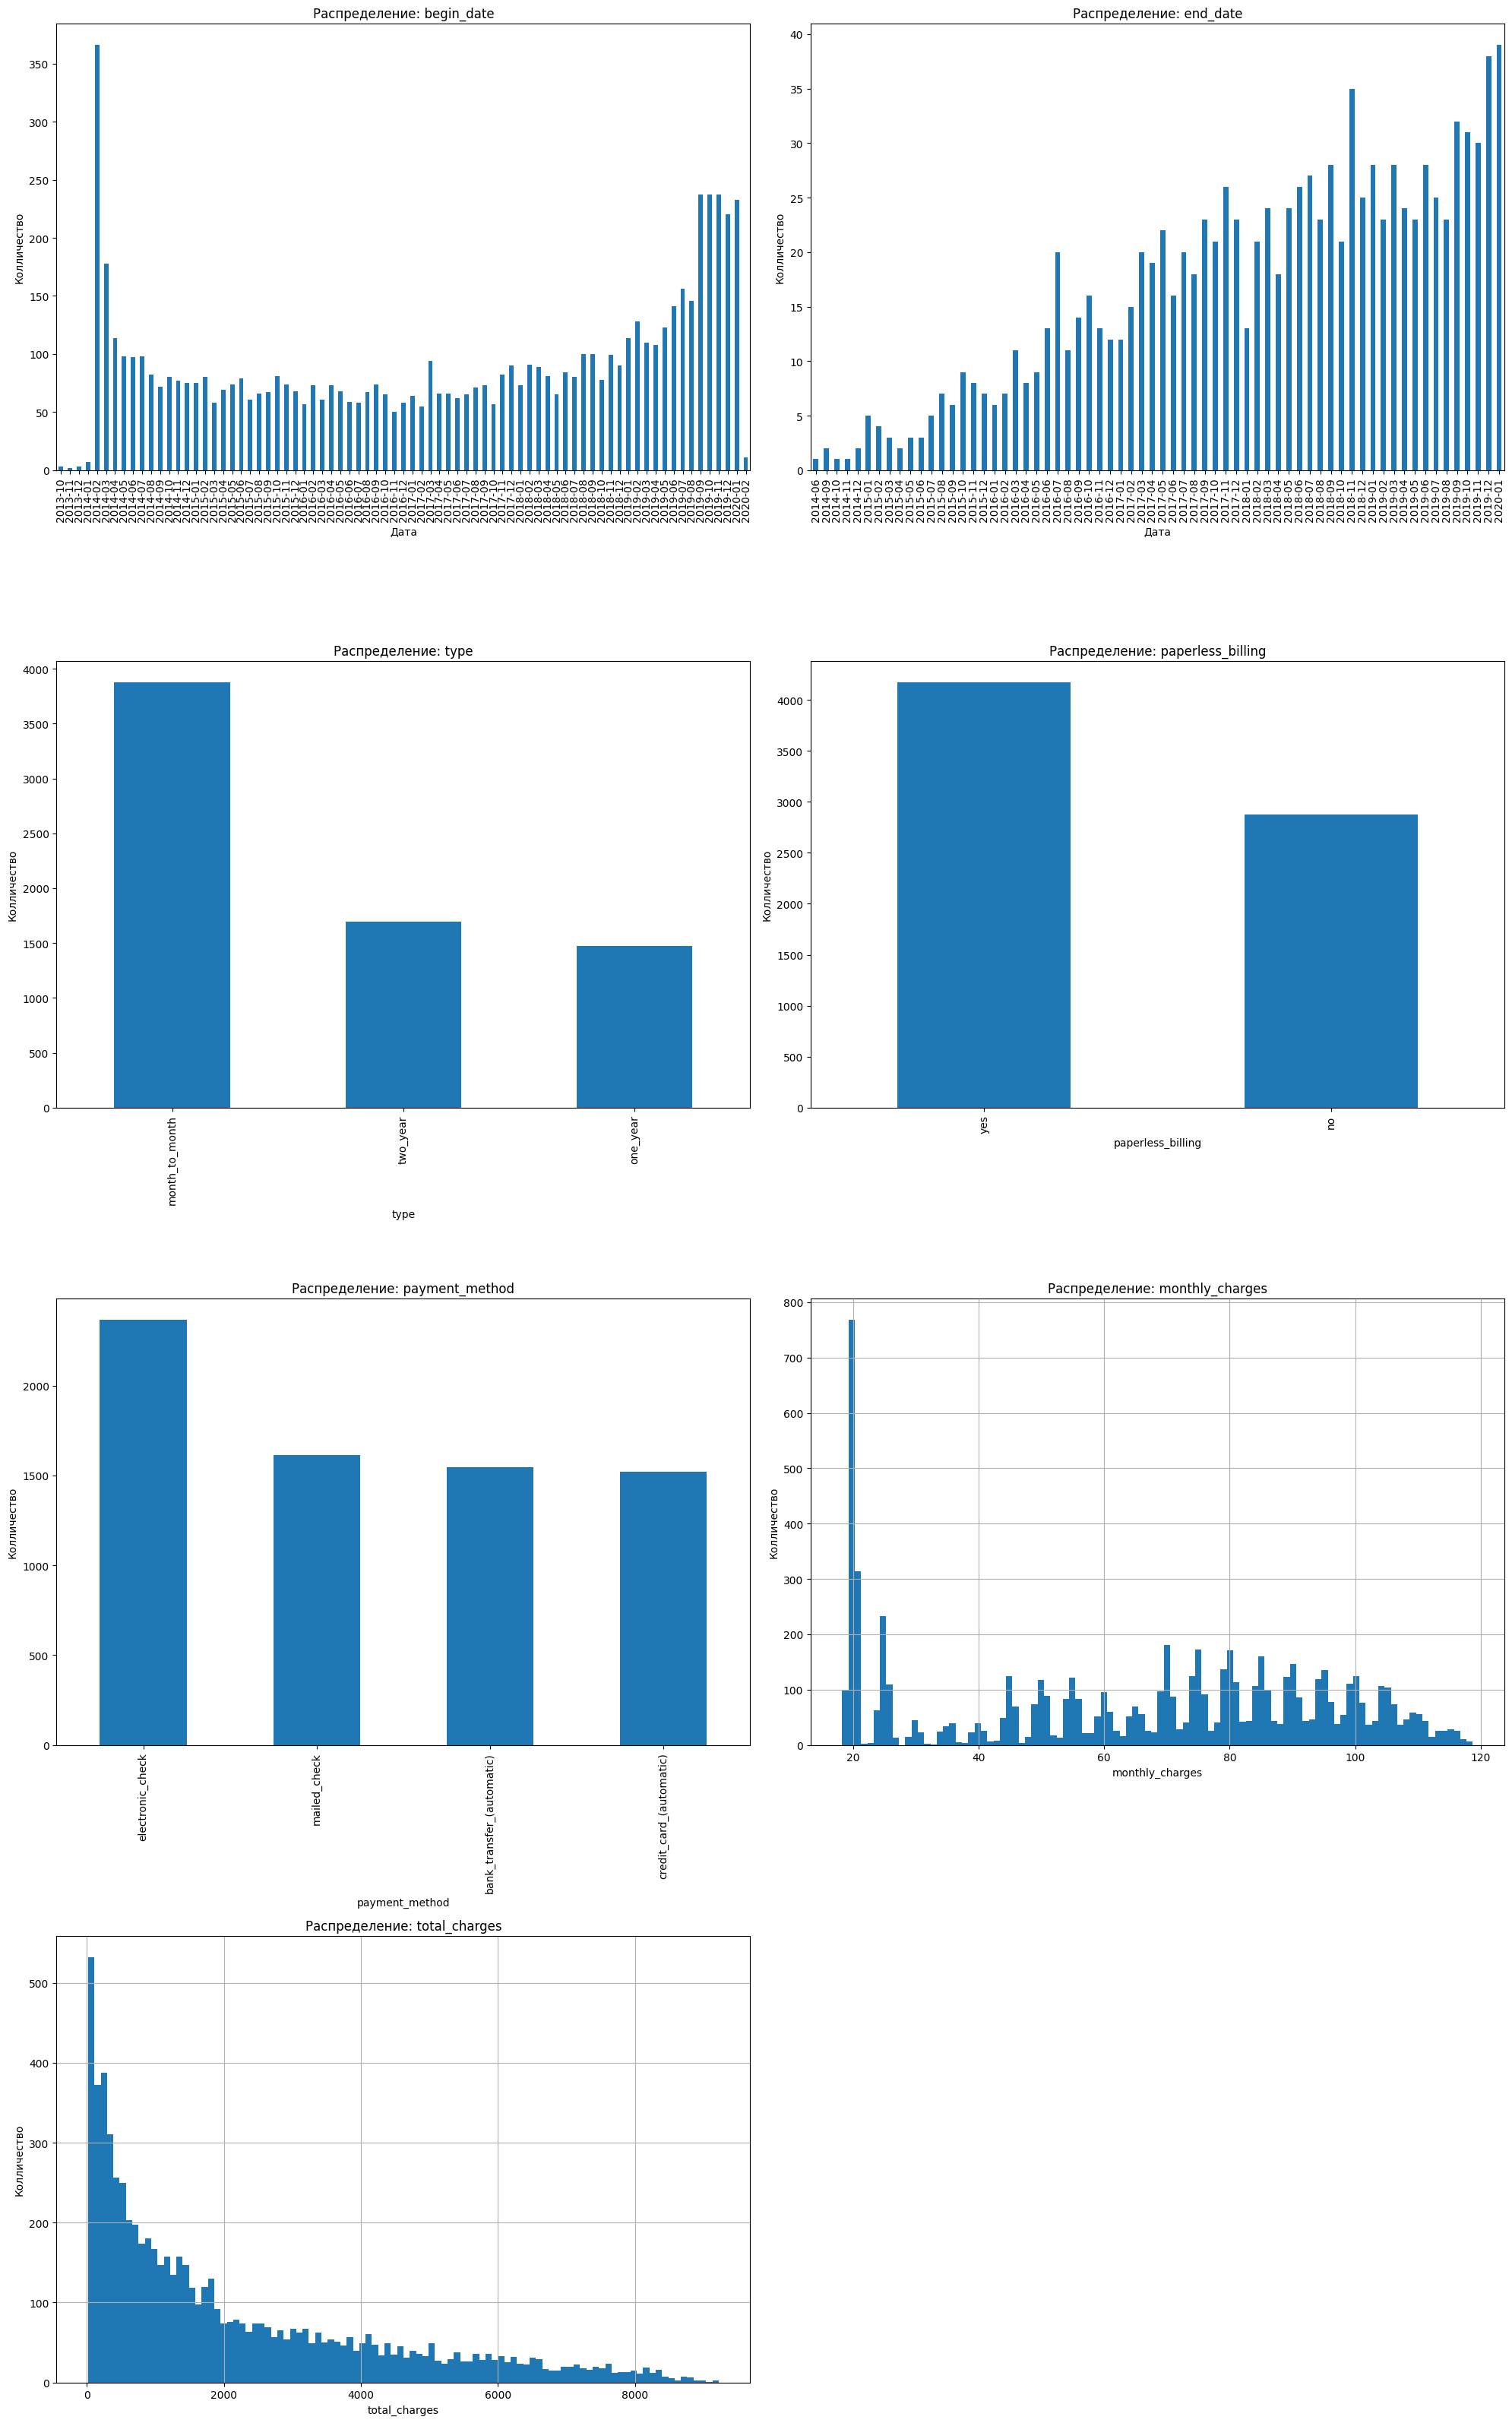

In [30]:
plots(contract)


In [31]:
contract.describe()

,monthly_charges,total_charges
count,7043.000000,7043.000000
mean,64.761692,2115.377573
std,30.090047,2112.678861
min,18.250000,19.050000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


В целом аномалий не наблюдается 

Видно, что в последнее время стало больше новых клиентов, возможно это клиенты, которые перезаключили контракты, которые окончились

Помесячная оплата преобладает над оплатой за год или за два года.

Большинство клиентов используют самый дешёвый тариф, также большинство контрактов принесло компании меньше 2000

### Изучение таблицы personal

In [32]:
personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [33]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


In [34]:
personal.columns = (
    personal.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
    .str.lower()
)

personal.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)


In [35]:
for col in personal.select_dtypes(include='object').columns:
    personal[col] = personal[col].str.strip().str.replace(' ', '_').str.lower()

In [36]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


In [37]:
personal.isna().sum()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

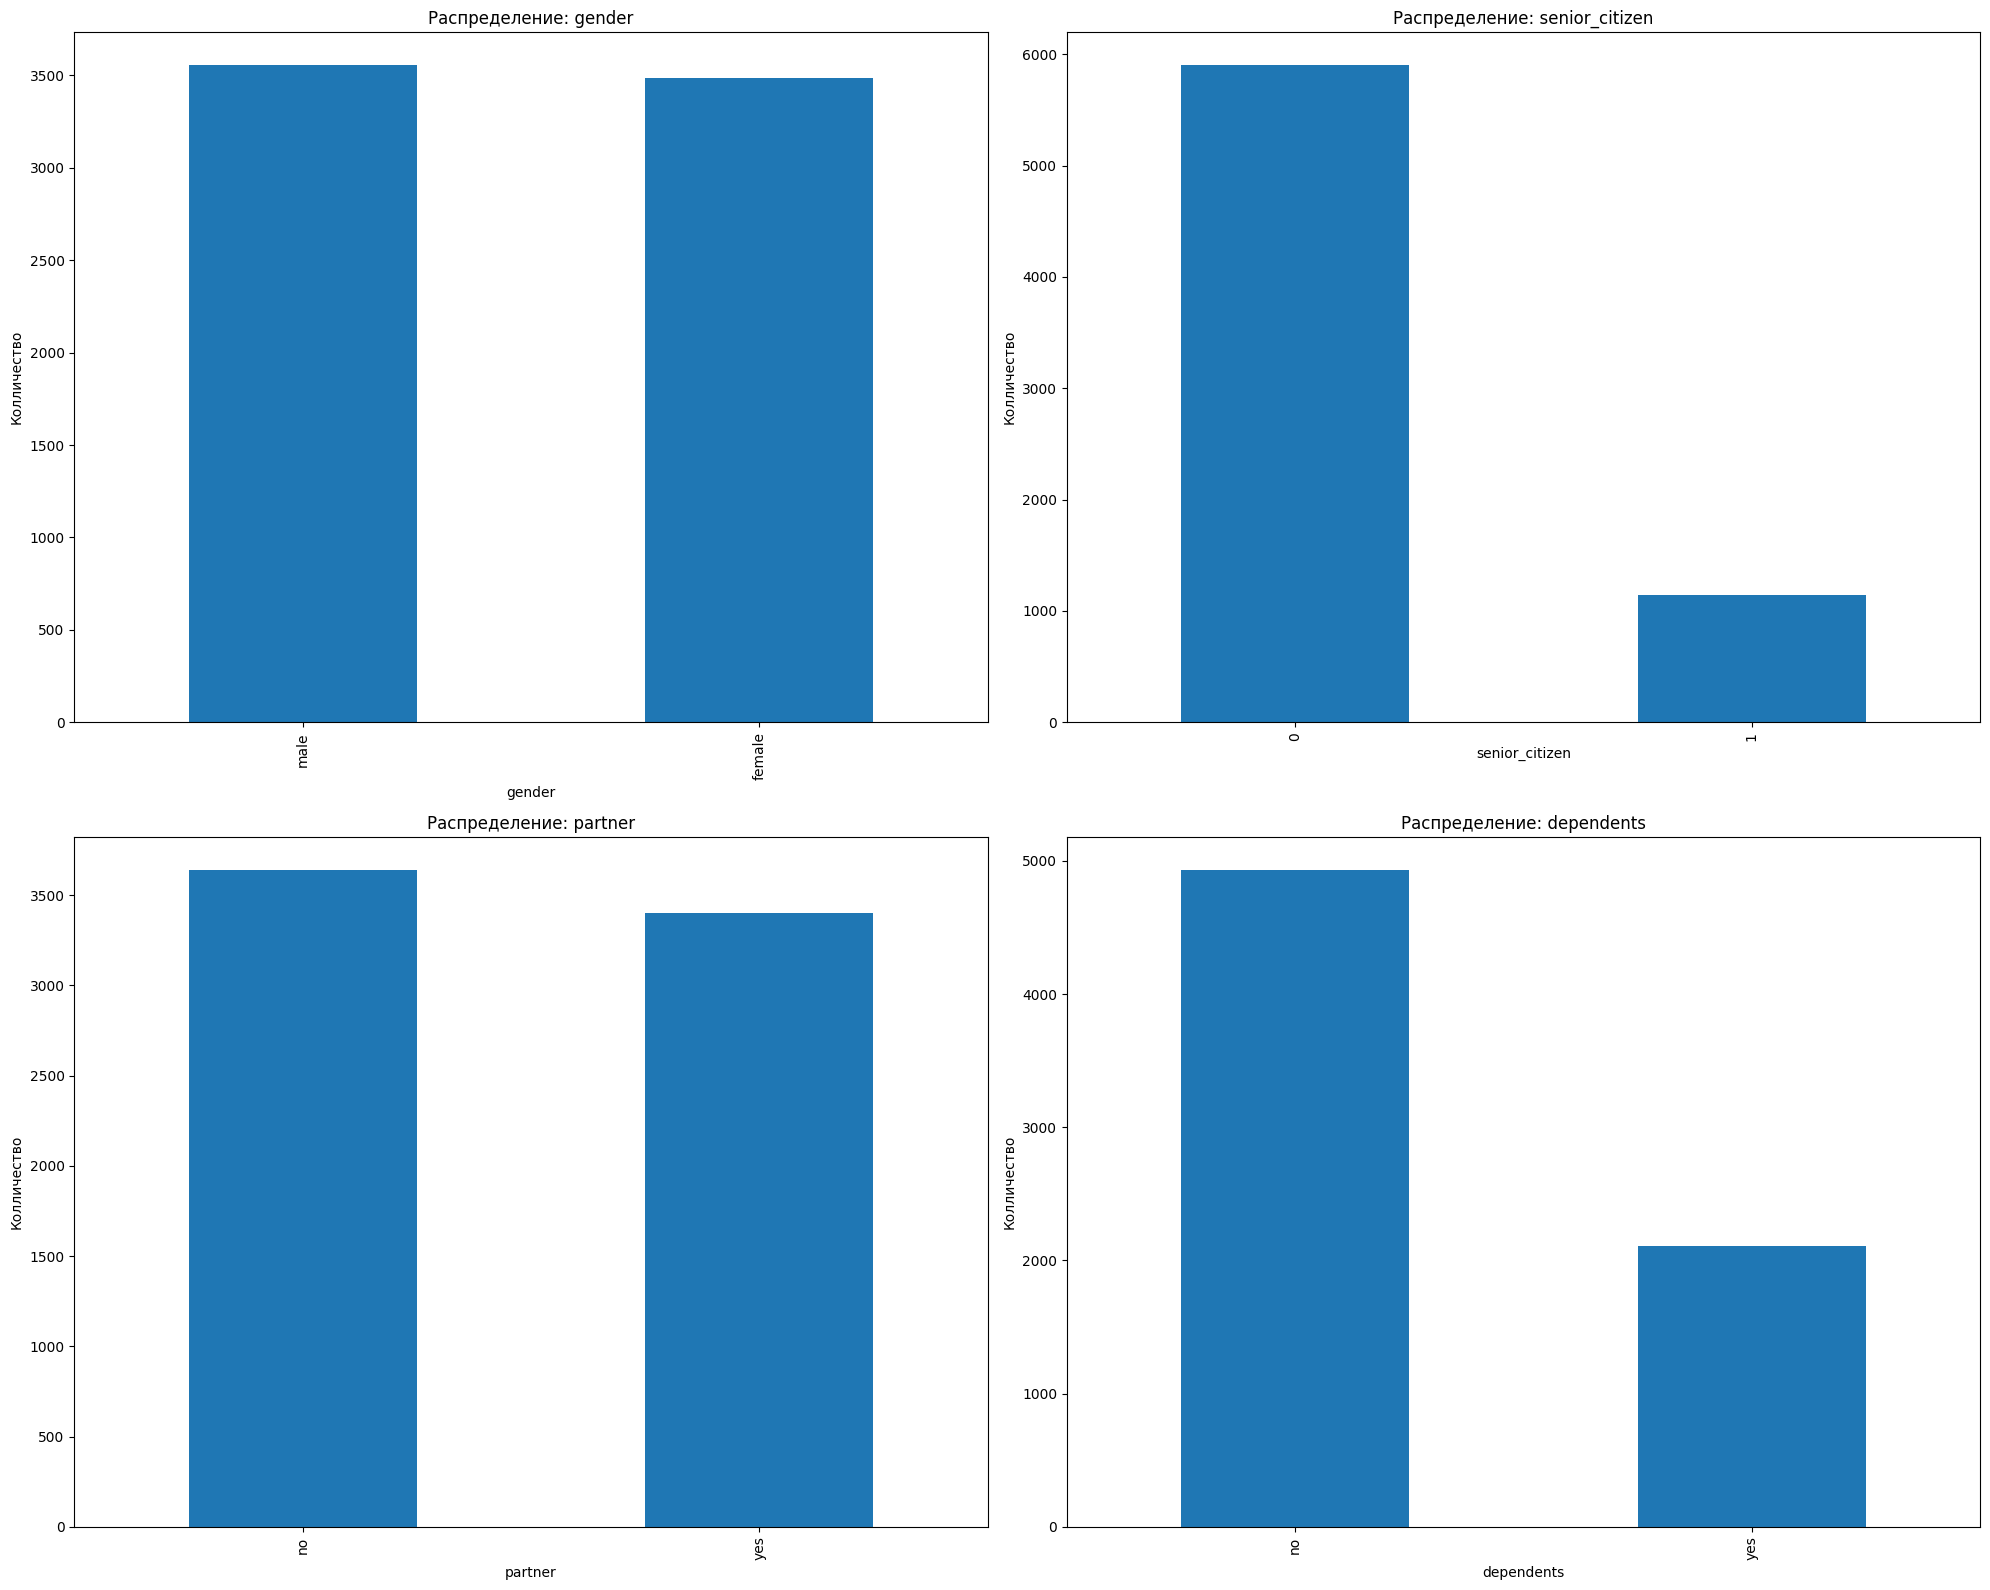

In [38]:
plots(personal)

In [39]:
personal['senior_citizen'].value_counts()

senior_citizen
0    5901
1    1142
Name: count, dtype: int64

Среди клиентов примерно одинаковое колличество мужчин и женщин

Лишь 15% клиентов являются пенсионерами

Почти у половина клиентов состоит в браке

У большинства клиентов нет детей

### Изучение таблицы phone

In [40]:
phone.head(5)

,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [41]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Колличество строк меньше, чем в предыдущих таблицах

In [42]:
phone.columns = (
    phone.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
    .str.lower()
)

phone.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)

In [43]:
phone['customer_id'] = phone['customer_id'].str.strip().str.replace(' ', '_').str.lower()

In [44]:
phone.head(5)

,customer_id,multiple_lines
0,5575-gnvde,No
1,3668-qpybk,No
2,9237-hqitu,No
3,9305-cdskc,Yes
4,1452-kiovk,Yes


In [45]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [46]:
phone['multiple_lines'].value_counts()


multiple_lines
No     3390
Yes    2971
Name: count, dtype: int64

Примерно у половины клиентов подключено несколько телефонов

### Изучение таблицы internet

In [47]:
internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [48]:
internet.columns = (
    internet.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
    .str.lower()
)
internet.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)


In [49]:
internet['customer_id'] = internet['customer_id'].str.strip().str.replace(' ', '_').str.lower()

In [50]:
internet.head(5)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
0,7590-vhveg,DSL,No,Yes,No,No,No,No
1,5575-gnvde,DSL,Yes,No,Yes,No,No,No
2,3668-qpybk,DSL,Yes,Yes,No,No,No,No
3,7795-cfocw,DSL,Yes,No,Yes,Yes,No,No
4,9237-hqitu,Fiber optic,No,No,No,No,No,No


In [51]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_t_v      5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Колличество строк в таблице отличается от колличества строк в других таблицах

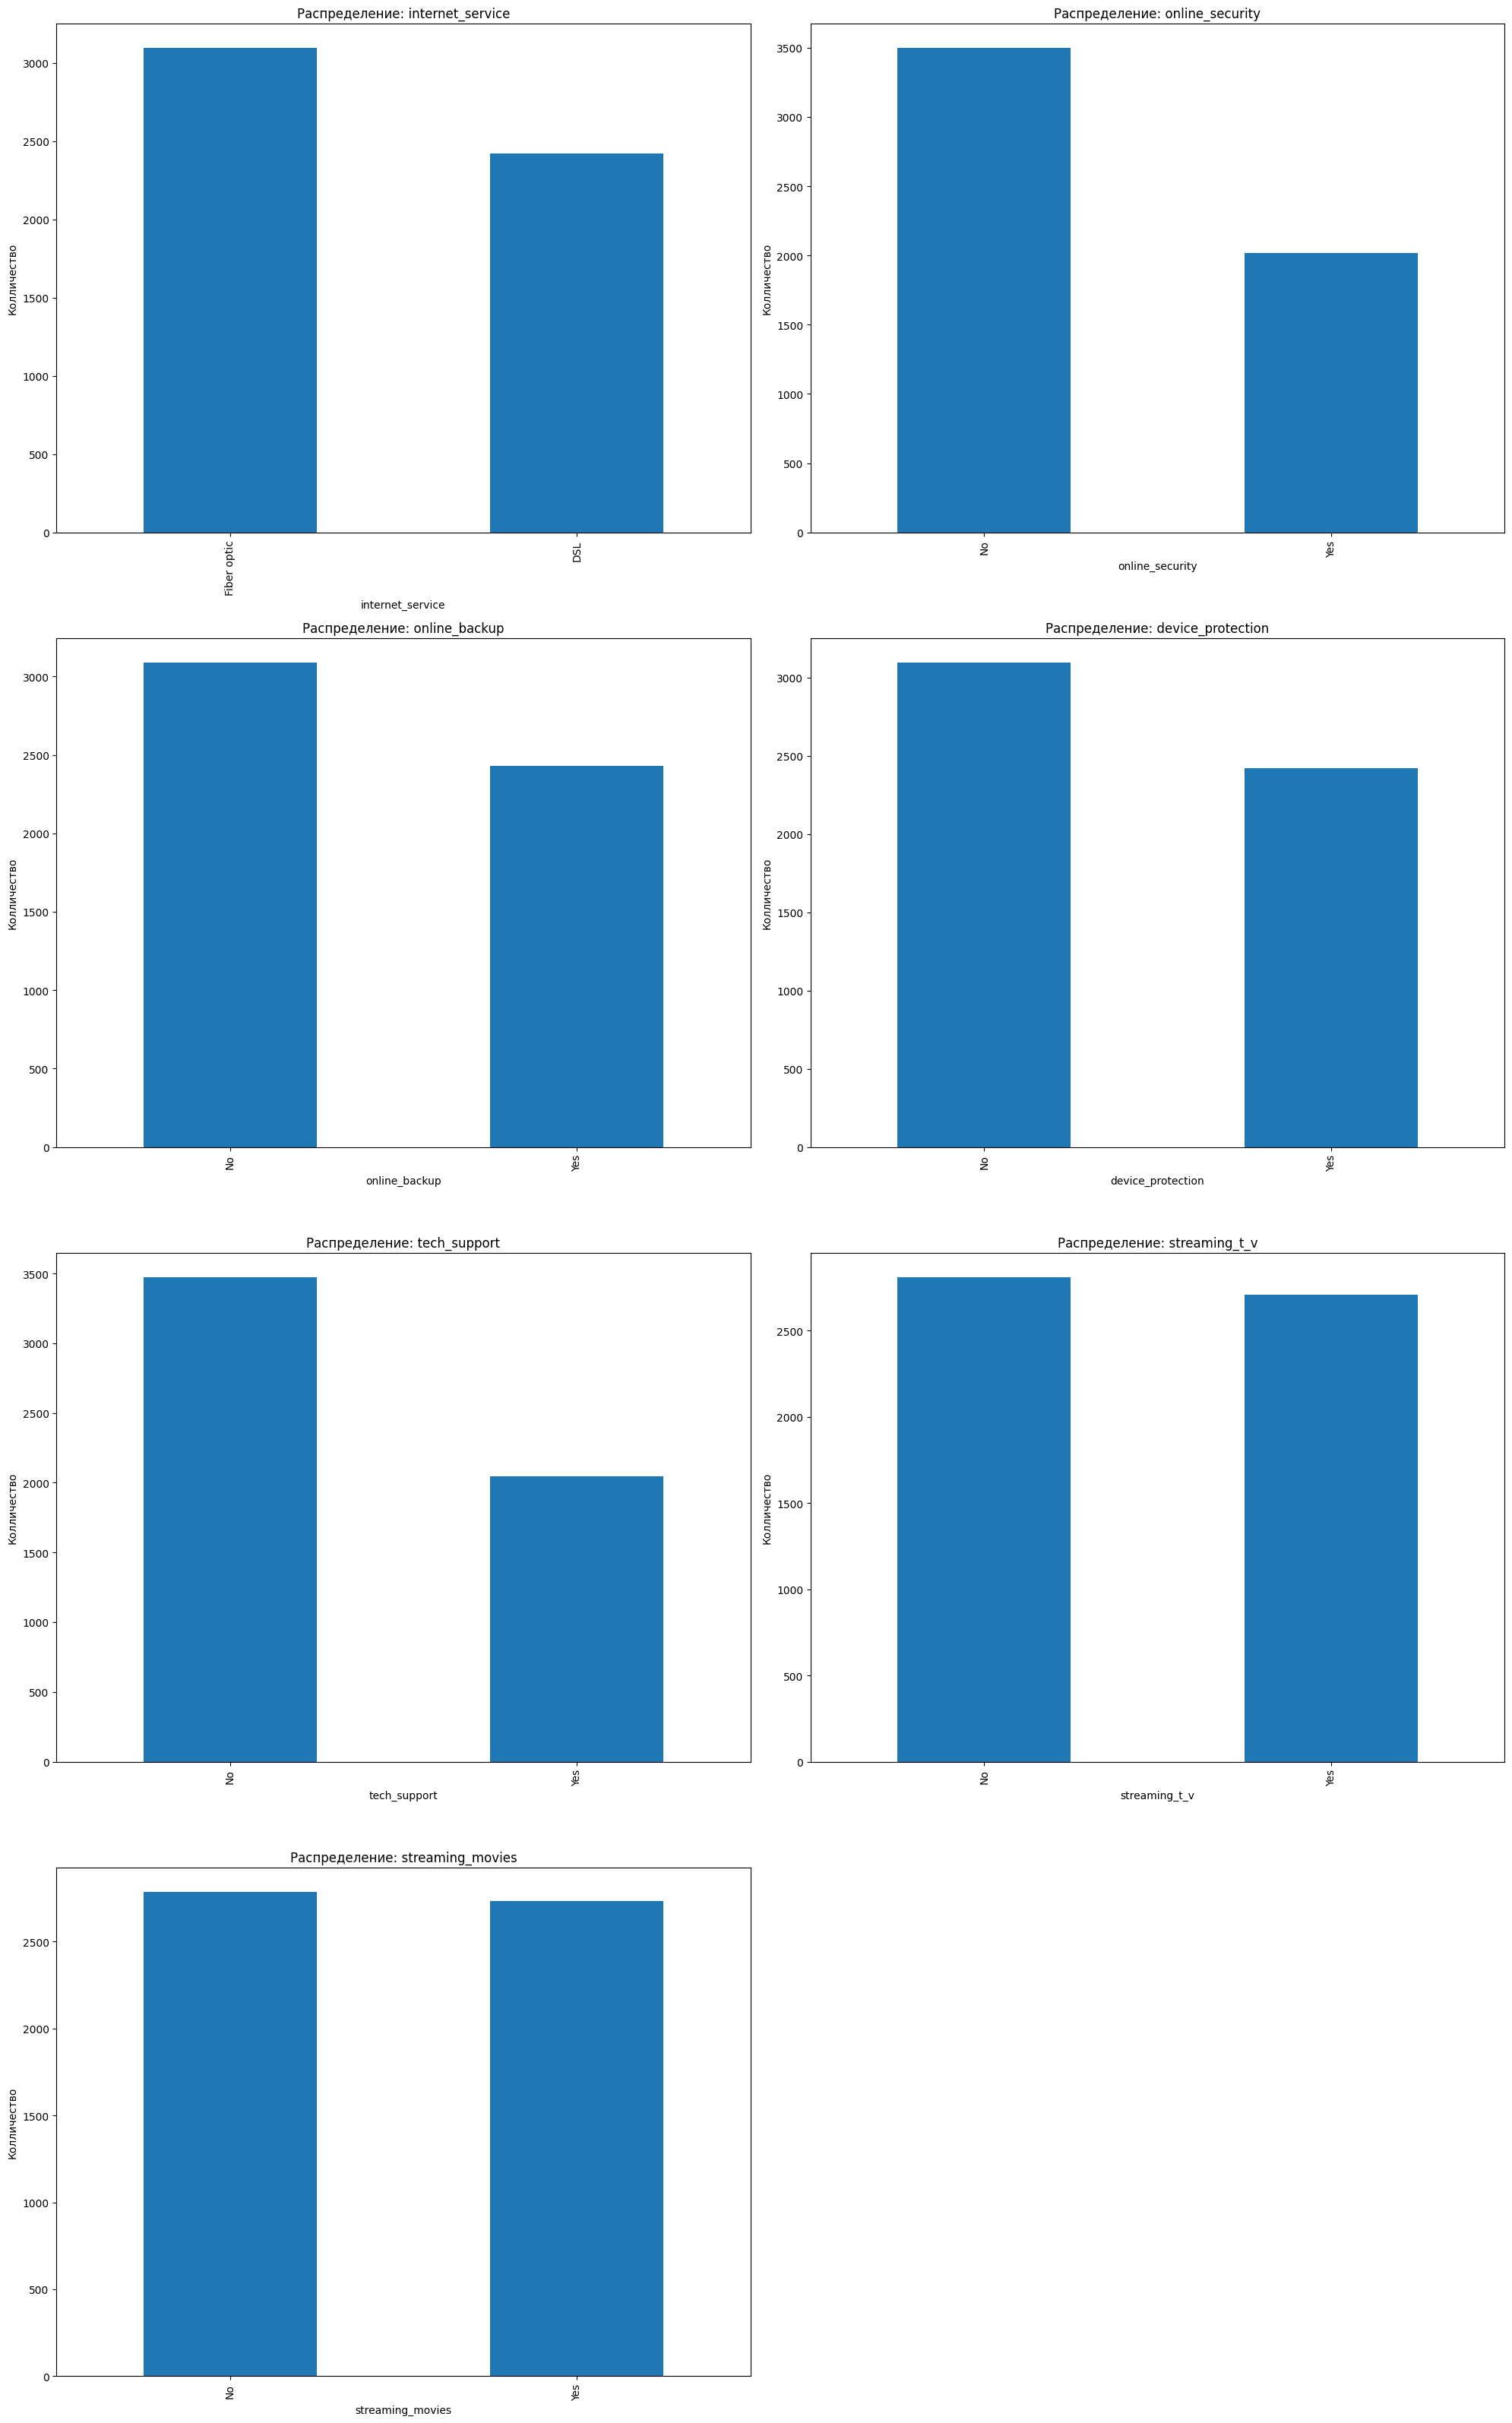

In [52]:
plots(internet)

Видно, что всеми типами услуг пользуется меньше 50% клиентов

### Вывод

Был проведён анализ имеющихся данных, аномалии не были обнаружены, всего в датасете содержится 7043 строк, в двух последних таблицах записей меньше, нужно будет обработать пропуски, которые появятся после объединения. 

## Объеденение таблиц

In [53]:
df = contract.merge(personal, on='customer_id', how='left') \
                  .merge(phone, on='customer_id', how='left') \
                  .merge(internet, on='customer_id', how='left')


In [54]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
0,7590-vhveg,2020-01-01,NaN,month_to_month,yes,electronic_check,29.85,31.04,female,0,yes,no,NaN,DSL,No,Yes,No,No,No,No
1,5575-gnvde,2017-04-01,NaN,one_year,no,mailed_check,56.95,2071.84,male,0,no,no,No,DSL,Yes,No,Yes,No,No,No
2,3668-qpybk,2019-10-01,NaN,month_to_month,yes,mailed_check,53.85,226.17,male,0,no,no,No,DSL,Yes,Yes,No,No,No,No
3,7795-cfocw,2016-05-01,NaN,one_year,no,bank_transfer_(automatic),42.30,1960.60,male,0,no,no,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-hqitu,2019-09-01,NaN,month_to_month,yes,electronic_check,70.70,353.50,female,0,no,no,No,Fiber optic,No,No,No,No,No,No


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           1101 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   object 
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     6361 non-null   object 
 13  internet_service   5517 non-null   object 
 14  online_security    5517 non-null   object 
 15  online_backup      5517 non-null   object 
 16  device_protection  5517 

Таблицы были успешно объединены. 

### Добавление новых признаков

Длительность контракта

In [56]:
now = pd.to_datetime('2020-02-01')  
df['begin_date'] = pd.to_datetime(df['begin_date'])
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')
df['contract_duration'] = (df['end_date'].fillna(now) - df['begin_date']).dt.days


Колличество используемых услуг

In [57]:
service_cols = [
    'multiple_lines', 'online_security', 'online_backup', 
    'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies'
]

n_services = df[service_cols].apply(
    lambda row: sum([(x == 'Yes') or (x == 'True') or (x is True) for x in row]), axis=1
)
df['n_services'] = n_services.astype(int)



Добавлены два новых признака: время длительности контракта и количество услуг, которыми пользуется клиент. 

### Анализ объеденённых таблиц

In [58]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,contract_duration,n_services
0,7590-vhveg,2020-01-01,NaT,month_to_month,yes,electronic_check,29.85,31.04,female,0,...,NaN,DSL,No,Yes,No,No,No,No,31,1
1,5575-gnvde,2017-04-01,NaT,one_year,no,mailed_check,56.95,2071.84,male,0,...,No,DSL,Yes,No,Yes,No,No,No,1036,2
2,3668-qpybk,2019-10-01,NaT,month_to_month,yes,mailed_check,53.85,226.17,male,0,...,No,DSL,Yes,Yes,No,No,No,No,123,2
3,7795-cfocw,2016-05-01,NaT,one_year,no,bank_transfer_(automatic),42.30,1960.60,male,0,...,NaN,DSL,Yes,No,Yes,Yes,No,No,1371,3
4,9237-hqitu,2019-09-01,NaT,month_to_month,yes,electronic_check,70.70,353.50,female,0,...,No,Fiber optic,No,No,No,No,No,No,153,0


In [59]:
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')
end_day = pd.to_datetime('2020-02-01')  

df['target'] = (df['end_date'].notna()) & (df['end_date'] <= end_day)

In [60]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,contract_duration,n_services,target
0,7590-vhveg,2020-01-01,NaT,month_to_month,yes,electronic_check,29.85,31.04,female,0,...,DSL,No,Yes,No,No,No,No,31,1,False
1,5575-gnvde,2017-04-01,NaT,one_year,no,mailed_check,56.95,2071.84,male,0,...,DSL,Yes,No,Yes,No,No,No,1036,2,False
2,3668-qpybk,2019-10-01,NaT,month_to_month,yes,mailed_check,53.85,226.17,male,0,...,DSL,Yes,Yes,No,No,No,No,123,2,False
3,7795-cfocw,2016-05-01,NaT,one_year,no,bank_transfer_(automatic),42.30,1960.60,male,0,...,DSL,Yes,No,Yes,Yes,No,No,1371,3,False
4,9237-hqitu,2019-09-01,NaT,month_to_month,yes,electronic_check,70.70,353.50,female,0,...,Fiber optic,No,No,No,No,No,No,153,0,False


In [61]:
df['type'].value_counts()

type
month_to_month    3875
two_year          1695
one_year          1473
Name: count, dtype: int64

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  multiple_lines     6361 non-null   object        
 13  internet_service   5517 non-null   object        
 14  online_s

Думаю, что нужно заполнить пропуски False так как, если по клиенту нет данных, значит, что услуга у него не подключена

In [63]:
cat_c = [
    'multiple_lines','internet_service', 'online_security', 'online_backup', 'device_protection',
    'tech_support', 'streaming_t_v', 'streaming_movies']


df[cat_c] = df[cat_c].fillna('not_used')

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  multiple_lines     7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14  online_s

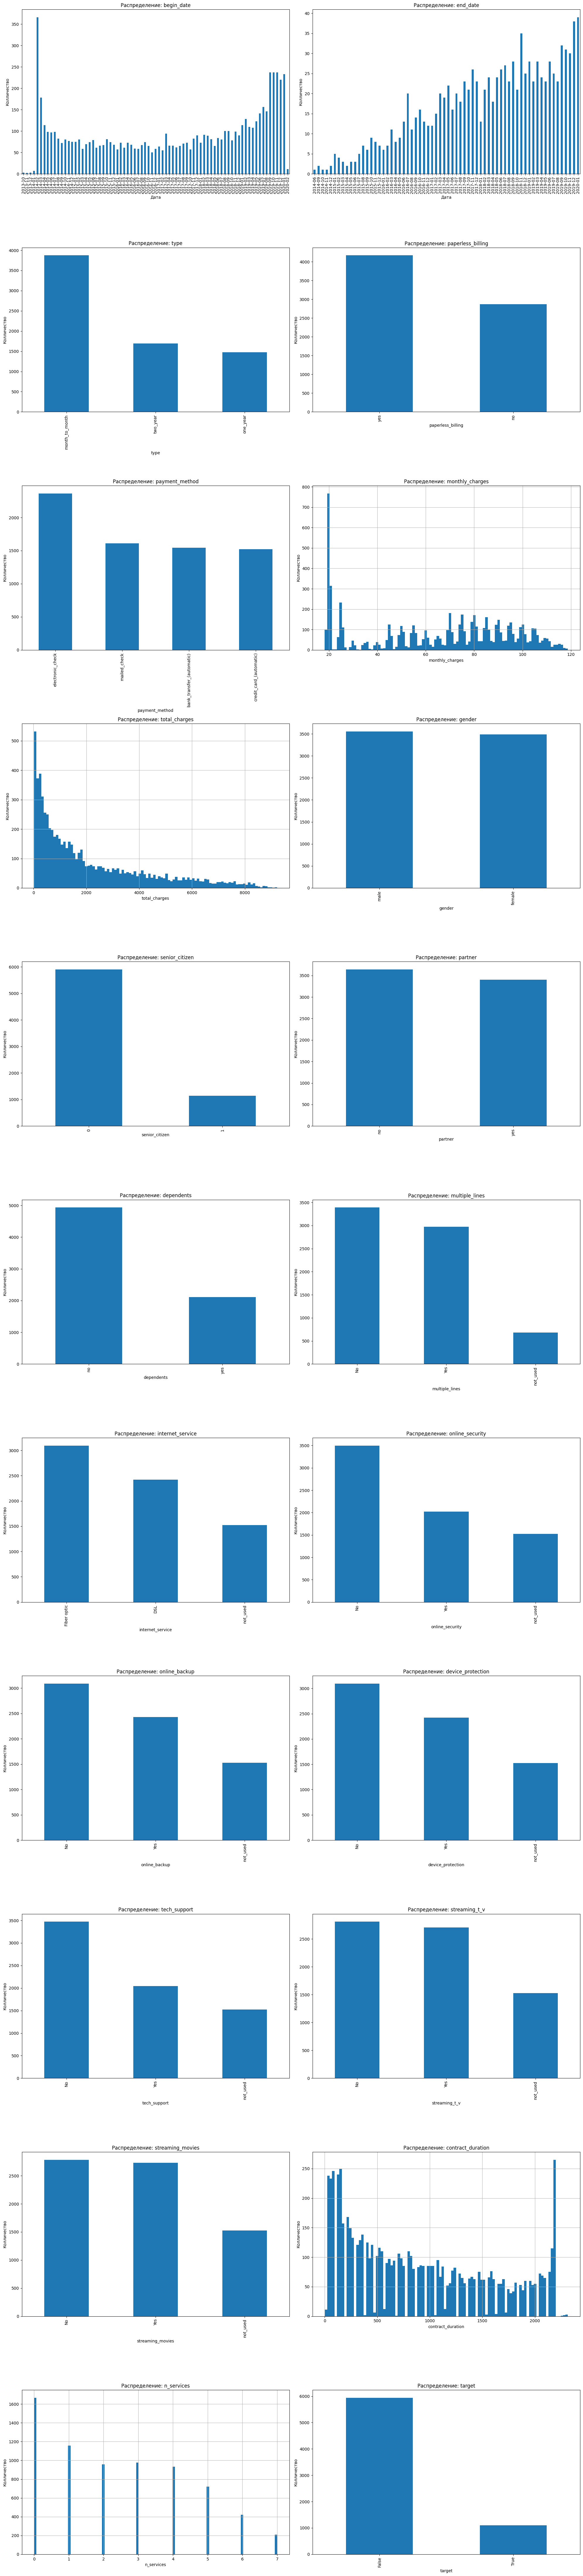

In [65]:
plots(df)

С данными всё хорошо

Визуализируем соотношение ушедших и оставшихся клиентов для каждого признака

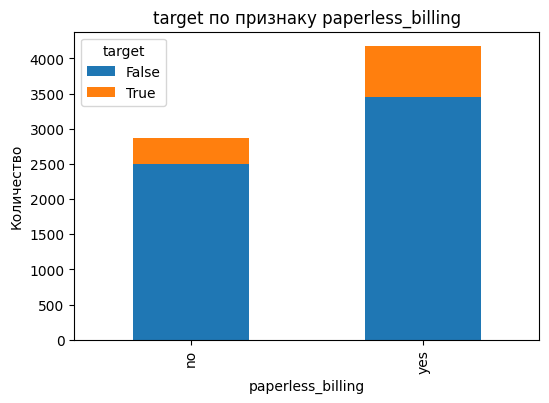

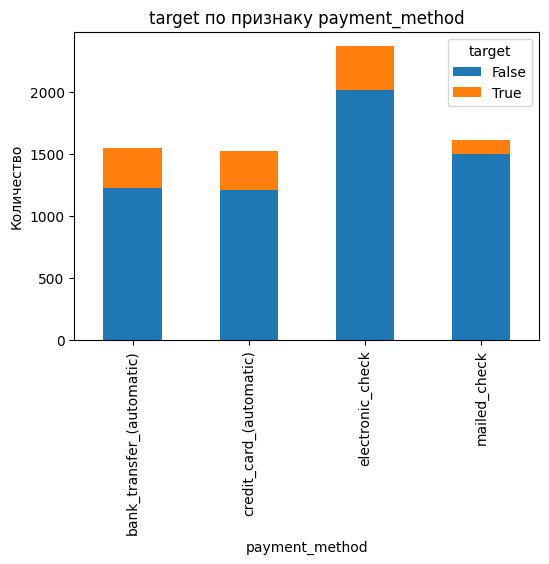

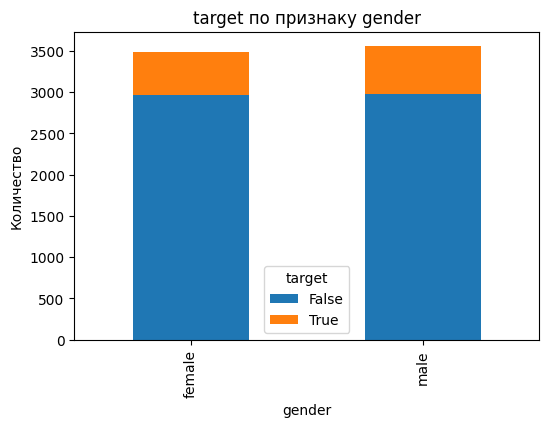

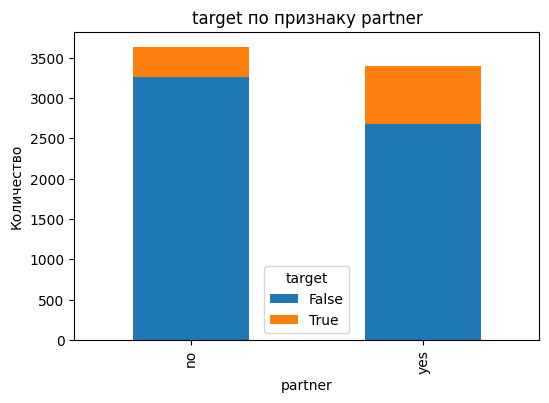

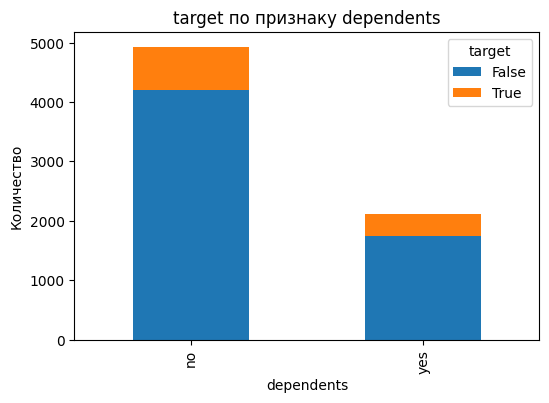

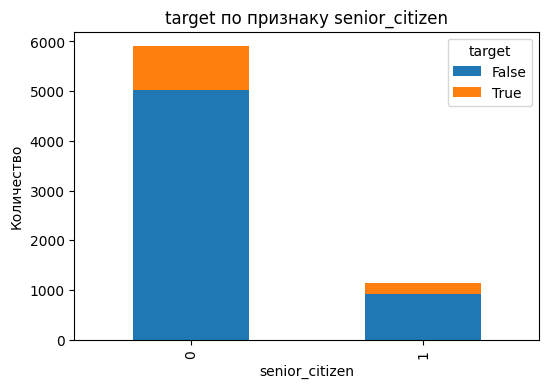

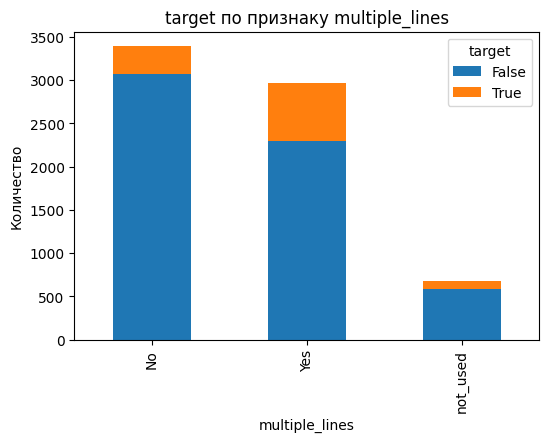

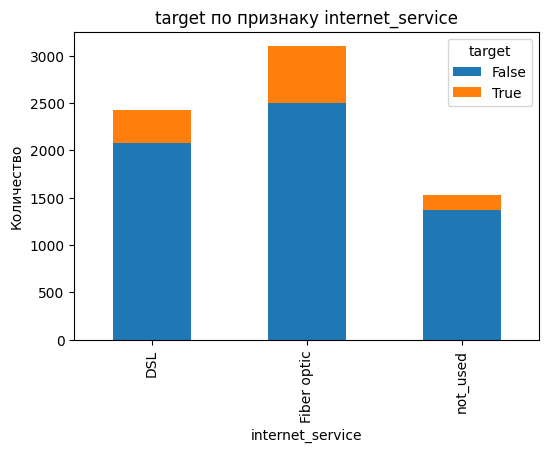

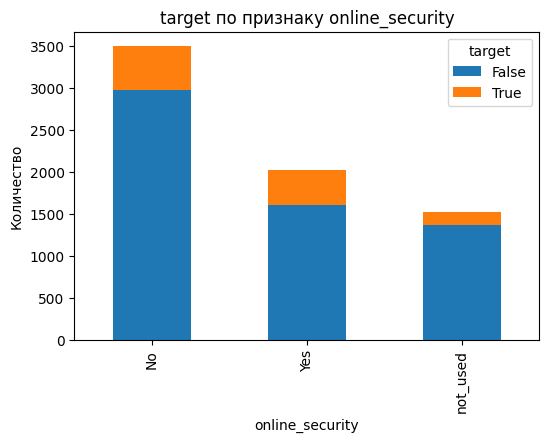

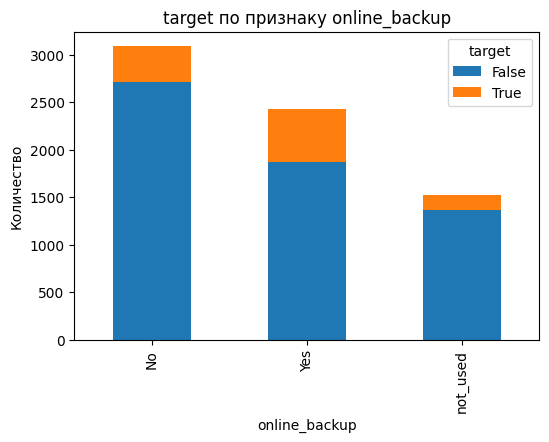

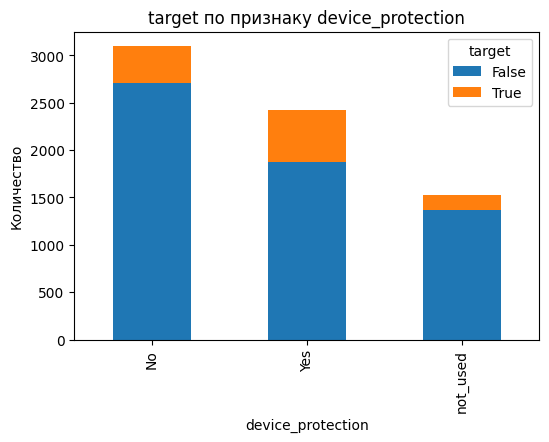

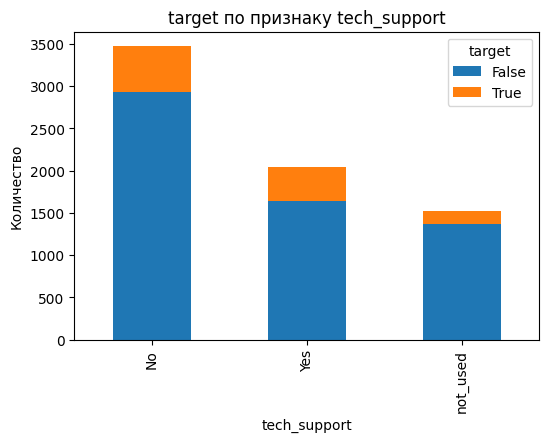

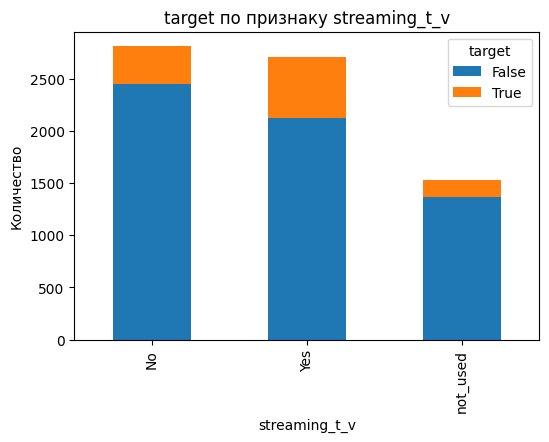

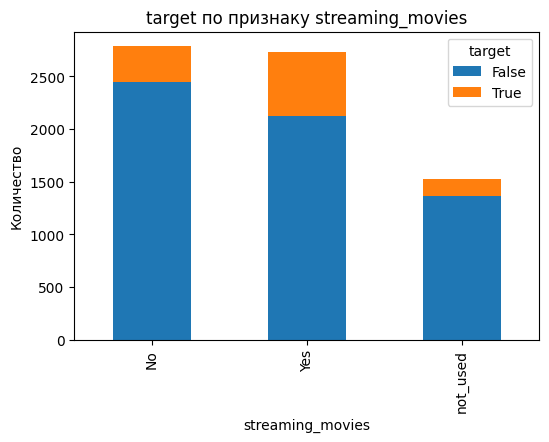

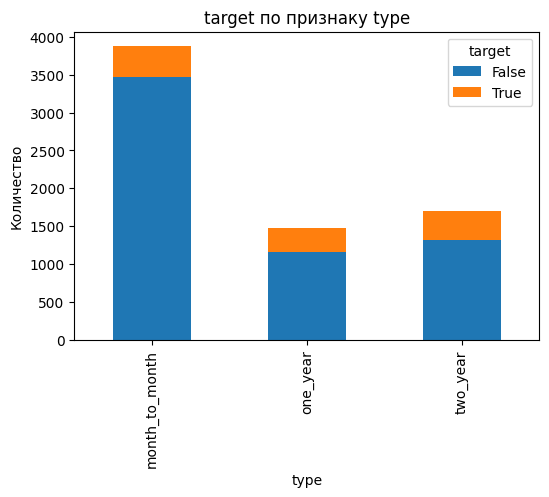

In [66]:
categorical_features = [
    'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents', 
    'senior_citizen', 'multiple_lines', 'internet_service', 'online_security',
    'online_backup', 'device_protection', 'tech_support', 
    'streaming_t_v', 'streaming_movies', 'type'
]

for feature in categorical_features:
    df.groupby([feature, 'target']).size().unstack().plot(
        kind='bar', stacked=True, figsize=(6,4)
    )
    plt.title(f'target по признаку {feature}')
    plt.ylabel('Количество')
    plt.show()


Основные факторы риска — помесячный контракт, электронный чек, отсутствие дополнительных сервисов, отсутствие партнёра/иждивенцев и статус пенсионера.
Для удержания стоит предлагать клиентам долгосрочные тарифы, переводить их на безналичные методы оплаты (кроме электронного чека) и стимулировать использование дополнительных сервисов.



### Корреляционный анализ

В нашем случае Phik-корреляция выглядит предпочтительнее, чем корреляция Пирсона, так как в данных содержится много булевых (категориальных) признаков. Коэффициент Пирсона хорошо работает только с количественными переменными, а Phik позволяет корректно оценивать связь между категориальными и смешанными типами признаков.

In [67]:
df_corr = df.drop(['customer_id', 'end_date', 'begin_date'], axis=1)

interval_cols = [
    'monthly_charges',
    'total_charges',
    'contract_duration', 
]

Исправил

К числовым непрерывным признакам относятся `monthly_charges` `total_charges` `contract_duration`

In [68]:
phik_corr = df_corr.phik_matrix(interval_cols=interval_cols)
print(phik_corr['target'].sort_values(ascending=False))


target               1.000000
contract_duration    0.374569
total_charges        0.304287
n_services           0.285289
partner              0.226688
monthly_charges      0.225925
payment_method       0.214832
multiple_lines       0.105101
type                 0.094015
online_backup        0.089704
streaming_movies     0.086577
senior_citizen       0.086159
device_protection    0.085608
paperless_billing    0.083398
streaming_t_v        0.078545
online_security      0.058659
internet_service     0.056621
tech_support         0.051537
dependents           0.046871
gender               0.008581
Name: target, dtype: float64


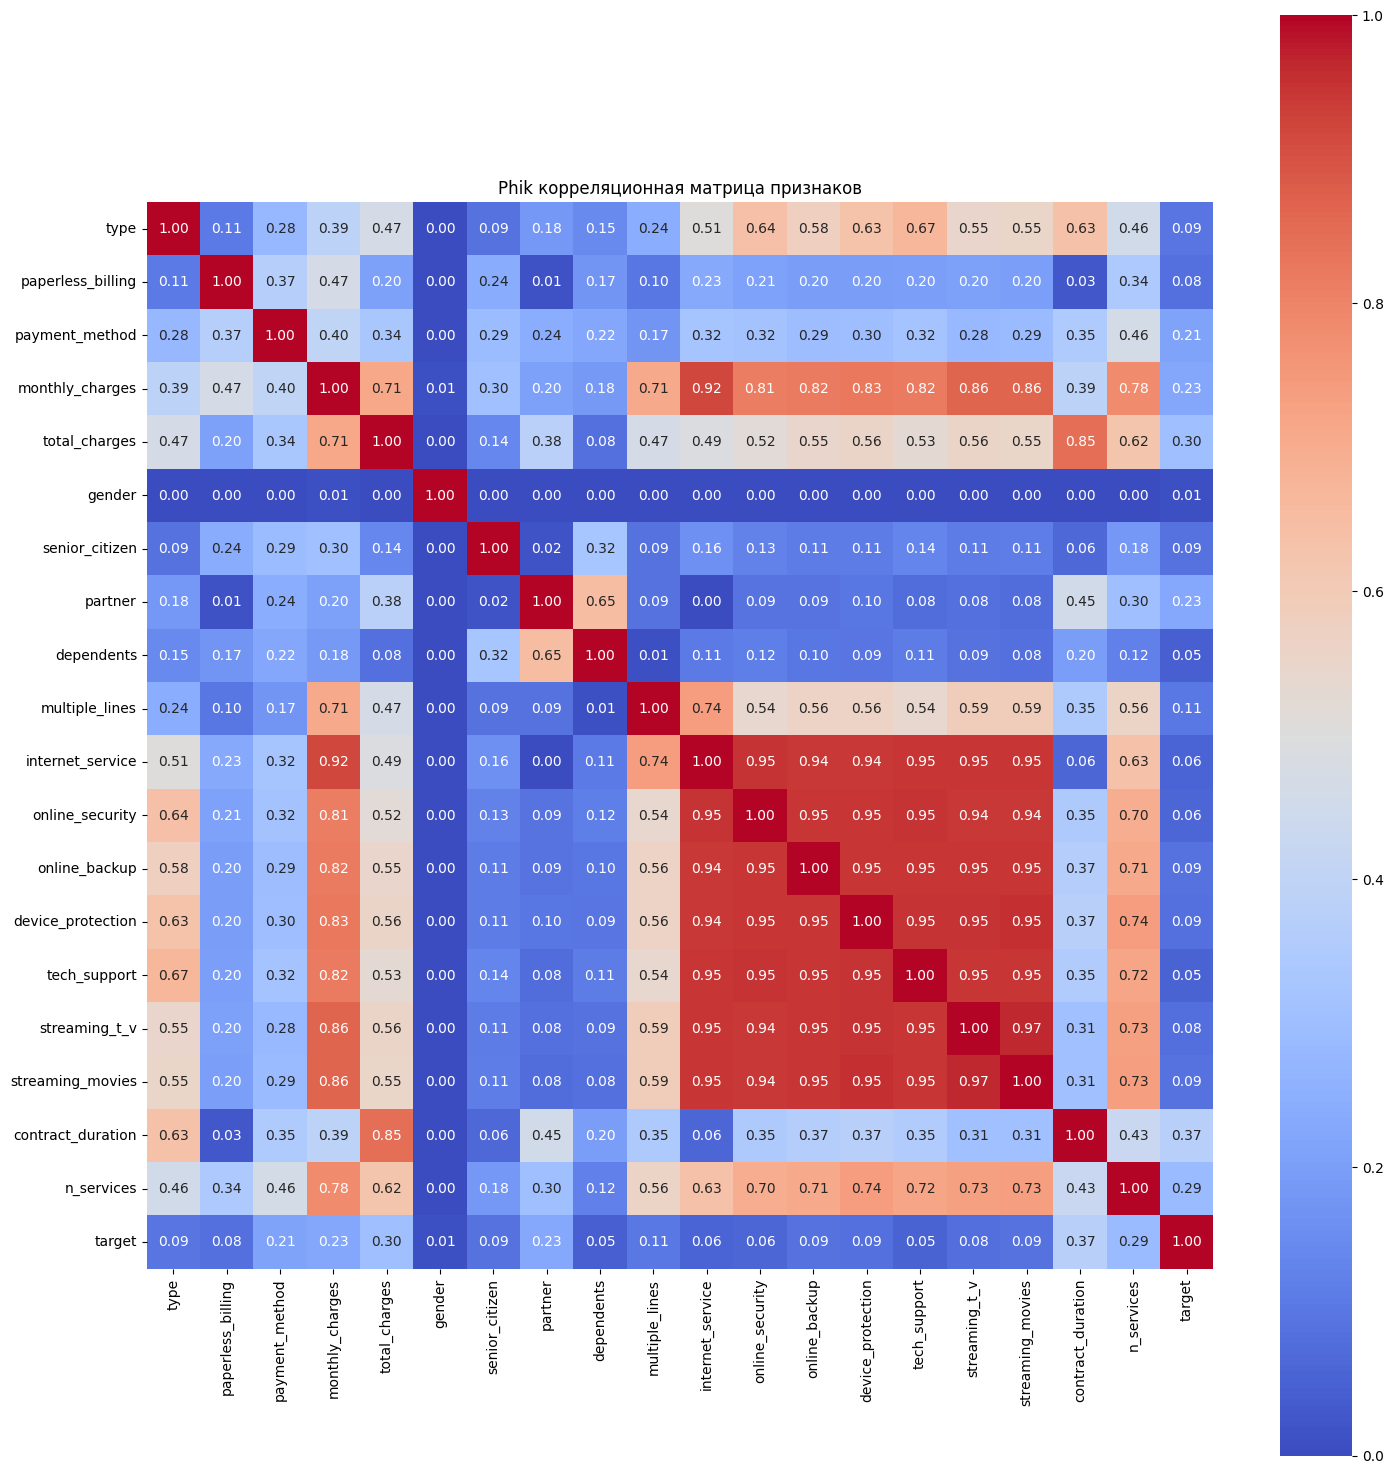

Phik-корреляция признаков с target:
target               1.000000
contract_duration    0.374569
total_charges        0.304287
n_services           0.285289
partner              0.226688
monthly_charges      0.225925
payment_method       0.214832
multiple_lines       0.105101
type                 0.094015
online_backup        0.089704
streaming_movies     0.086577
senior_citizen       0.086159
device_protection    0.085608
paperless_billing    0.083398
streaming_t_v        0.078545
online_security      0.058659
internet_service     0.056621
tech_support         0.051537
dependents           0.046871
gender               0.008581
Name: target, dtype: float64


In [69]:
plt.figure(figsize=(15, 15))  
sns.heatmap(
    phik_corr, 
    annot=True,       
    fmt=".2f",        
    cmap='coolwarm', 
    cbar=True, 
    square=True
)
plt.title('Phik корреляционная матрица признаков')
plt.tight_layout()
plt.show()


print('Phik-корреляция признаков с target:')
print(phik_corr['target'].sort_values(ascending=False))


Самый сильный положительный вклад в уход клиентов вносит длительность контракта (contract_duration), что говорит о том, что клиенты с более длительными контрактами чаще уходят.

Значимые корреляции наблюдаются также у общего количества потраченных средств (total_charges) и количества услуг (n_services) — большее количество услуг и сумма связаны с повышенным риском оттока.

Сигналы об уходе также дают признаки, связанные с типами услуг: multiple_lines, online_backup, partner, streaming_movies, device_protection и другие показывают умеренную положительную связь.

Признаки, связанные с демографией (senior_citizen) и бумажным биллингом, имеют очень слабое влияние.



## Обучение моделей

### Подготовка данных

In [70]:
X = df_corr.drop('target', axis=1)
y = df_corr['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

In [71]:
print(y.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


target
False    0.843675
True     0.156325
Name: proportion, dtype: float64
target
False    0.84362
True     0.15638
Name: proportion, dtype: float64
target
False    0.843839
True     0.156161
Name: proportion, dtype: float64


По результатам разделения баланс классов был сохранён.

### Модель случайного леса

In [72]:
numeric_features = ['monthly_charges', 'total_charges', 'contract_duration', 'n_services']
other_features = [col for col in X_train.columns if col not in numeric_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), other_features)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])


In [73]:
def objective(trial):
    params = {
        'rf__n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'rf__max_depth': trial.suggest_int('max_depth', 2, 20),
        'rf__min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'rf__min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'rf__max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    pipeline.set_params(**params)
    score = cross_val_score(
        pipeline, X_train, y_train, 
        scoring='roc_auc', cv=5, n_jobs=-1
    ).mean()
    return score

In [74]:
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
study_rf = optuna.create_study(direction='maximize', sampler=sampler)
study_rf.optimize(objective, n_trials=30)

[I 2025-05-22 17:52:20,953] A new study created in memory with name: no-name-6d351f69-089e-4418-8e88-9db418203498
[I 2025-05-22 17:52:22,809] Trial 0 finished with value: 0.8224430780929202 and parameters: {'n_estimators': 240, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 0 with value: 0.8224430780929202.
[I 2025-05-22 17:52:24,670] Trial 1 finished with value: 0.8224577891897775 and parameters: {'n_estimators': 182, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 1 with value: 0.8224577891897775.
[I 2025-05-22 17:52:25,154] Trial 2 finished with value: 0.80918110682077 and parameters: {'n_estimators': 88, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8224577891897775.
[I 2025-05-22 17:52:25,431] Trial 3 finished with value: 0.8156123176973203 and parameters: {'n_estimators': 51, 'max_depth': 14, 'min_sampl

In [75]:
print("Лучшие параметры:")
print(study_rf.best_params)

Лучшие параметры:
{'n_estimators': 225, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None}


Модель Случайного леса была обучена и получены лучшие параметры для неё 

### Модель CatBoost

In [76]:
numeric_features = ['monthly_charges', 'total_charges', 'contract_duration', 'n_services']
cat_features = [
    'type', 'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents',
    'multiple_lines', 'internet_service', 'online_security', 'online_backup',
    'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies'
]
all_features = numeric_features + cat_features
cat_feature_indices = list(range(len(numeric_features), len(numeric_features) + len(cat_features)))

X_train = X_train.copy()
for col in cat_features:
    X_train[col] = X_train[col].astype(str).fillna('missing')


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
    ],
    remainder='passthrough' 
)

def to_dataframe(X):
    return pd.DataFrame(X, columns=all_features)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_seed': RANDOM_STATE,
        'verbose': 0
    }
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('to_df', FunctionTransformer(to_dataframe)),
        ('catboost', CatBoostClassifier(cat_features=cat_feature_indices, **params))
    ])
    score = cross_val_score(
        pipeline, X_train[all_features], y_train,
        scoring='roc_auc', cv=5, n_jobs=-1
    ).mean()
    return score


In [77]:
study_cb = optuna.create_study(direction='maximize', sampler=sampler)
study_cb.optimize(objective, n_trials=30)

print("Лучшие параметры:")
print(study_cb.best_params)


[I 2025-05-22 17:53:03,982] A new study created in memory with name: no-name-79f6e588-1922-4f18-92ac-0020a93fe213
[I 2025-05-22 17:53:32,534] Trial 0 finished with value: 0.8380264505542625 and parameters: {'iterations': 414, 'depth': 8, 'learning_rate': 0.017945334663634658, 'l2_leaf_reg': 3.733551991552017}. Best is trial 0 with value: 0.8380264505542625.
[I 2025-05-22 17:54:25,477] Trial 1 finished with value: 0.8505969121020767 and parameters: {'iterations': 469, 'depth': 10, 'learning_rate': 0.06344127352460341, 'l2_leaf_reg': 1.6983915101422253}. Best is trial 1 with value: 0.8505969121020767.
[I 2025-05-22 17:55:08,800] Trial 2 finished with value: 0.8592888987731246 and parameters: {'iterations': 364, 'depth': 10, 'learning_rate': 0.171599354831165, 'l2_leaf_reg': 4.956280374178804}. Best is trial 2 with value: 0.8592888987731246.
[I 2025-05-22 17:55:16,286] Trial 3 finished with value: 0.8559162809041055 and parameters: {'iterations': 230, 'depth': 4, 'learning_rate': 0.106698

Лучшие параметры:
{'iterations': 375, 'depth': 5, 'learning_rate': 0.19503638720110725, 'l2_leaf_reg': 2.6476007306419183}


Модель CatBoost была обучена и получены лучшие параметры для неё 

### Модель нейронной сети 

In [78]:
def objective(trial):
    params = {
        'hidden_layer_sizes': tuple([trial.suggest_int('layer_size', 16, 128) for _ in range(trial.suggest_int('n_layers', 1, 3))]),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
        'solver': trial.suggest_categorical('solver', ['adam', 'lbfgs']),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-2, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
        'max_iter': 200,
        'random_state': RANDOM_STATE
    }
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), other_features),
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('mlp', MLPClassifier(**params))
    ])

    score = cross_val_score(
        pipeline, X_train, y_train,
        scoring='roc_auc', cv=5, n_jobs=-1
    ).mean()
    return score

In [79]:
study_nn = optuna.create_study(direction='maximize', sampler=sampler)
study_nn.optimize(objective, n_trials=30)

print("Лучшие параметры:")
print(study_nn.best_params)

[I 2025-05-22 18:02:54,643] A new study created in memory with name: no-name-d65ef1d7-4534-412c-b4ce-182ddef969c3
[I 2025-05-22 18:03:00,091] Trial 0 finished with value: 0.7021782215342431 and parameters: {'n_layers': 2, 'layer_size': 64, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.0007812162734570986, 'learning_rate_init': 0.0004590316595867114}. Best is trial 0 with value: 0.7021782215342431.
[I 2025-05-22 18:03:05,888] Trial 1 finished with value: 0.8319947804135512 and parameters: {'n_layers': 1, 'layer_size': 91, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0003713510270752161, 'learning_rate_init': 0.0006197481329596158}. Best is trial 1 with value: 0.8319947804135512.
[I 2025-05-22 18:03:13,054] Trial 2 finished with value: 0.7293150532817393 and parameters: {'n_layers': 3, 'layer_size': 69, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0022078727004366024, 'learning_rate_init': 0.00039963065310652025}. Best is trial 1 with value: 0.8319947804135512.
[I 

Лучшие параметры:
{'n_layers': 1, 'layer_size': 19, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0009098412927624769, 'learning_rate_init': 0.003370831165994627}


Модель нейронной сети была обучена и получены лучшие параметры для неё 

In [80]:
best_scores = {
    'RandomForest': study_rf.best_value, 
    'CatBoost': study_cb.best_value,     
    'NeuralNet': study_nn.best_value     
}

summary_df = pd.DataFrame.from_dict(
    best_scores, orient='index', columns=['ROC_AUC']
)
summary_df.index.name = 'Model'

In [81]:
summary_df

,ROC_AUC
Model,
RandomForest,0.831728
CatBoost,0.904921
NeuralNet,0.837174


По результатам обучения трёх моделей по метрике ROC_AUC лучшей оказалась модель CatBoost, её и будем использовать как основную

## Тестирование модели

In [82]:

best_params = study_cb.best_params

model = CatBoostClassifier(
    **best_params,
    random_seed=RANDOM_STATE,
    verbose=0
)

model.fit(X_train, y_train, cat_features=cat_features)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'ROC_AUC: {roc_auc:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

ROC_AUC: 0.9012
Accuracy: 0.9091
F1 Score: 0.6429


Accuracy (точность классификации) показывает долю правильно предсказанных наблюдений от общего числа. В нашем случае accuracy = 0.90 означает. То есть примерно 90 из 100 клиентов классифицируются моделью правильно

In [83]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict(X_test)

print('Dummy Accuracy:', accuracy_score(y_test, y_dummy_pred))
if len(set(y_test)) == 2:
    print('Dummy ROC_AUC:', roc_auc_score(y_test, y_dummy_pred))


Dummy Accuracy: 0.8438387279954571
Dummy ROC_AUC: 0.5


Наша модель показывает намного лучшиет результаты, чем константная модель

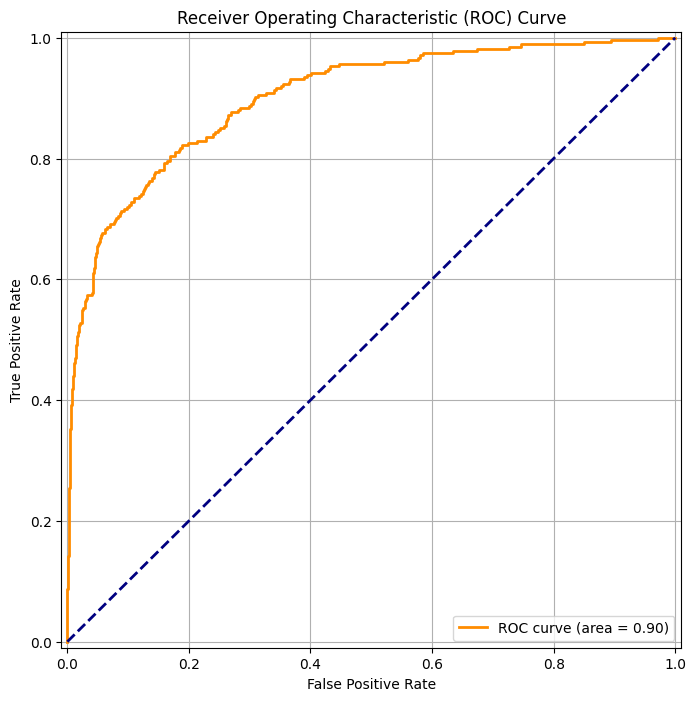

In [84]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Метрика на тестовых данных удовлетворяет условию ТЗ (0.92 > 0.85), что говорит о высокой способности модели отделять ушедших клиентов от оставшихся.



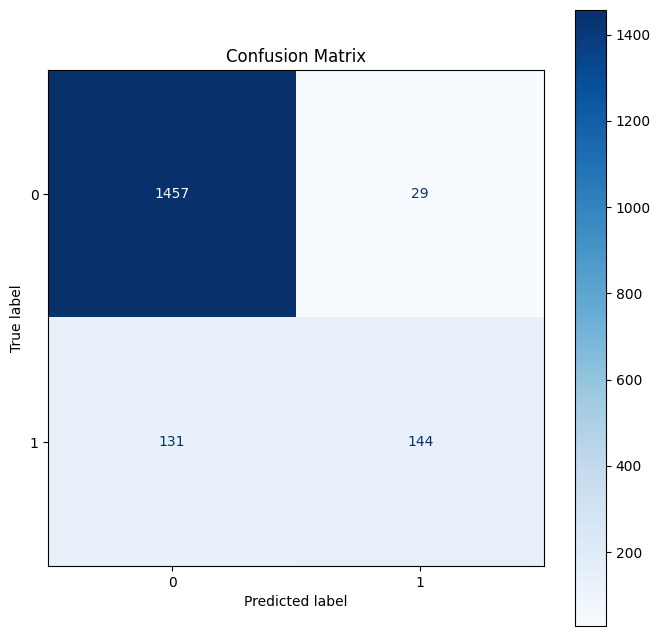

In [85]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=plt.gca()) 
plt.title('Confusion Matrix')
plt.show()


Модель сбалансирована, с уклоном в сторону консервативности (меньше FP). Это снижает риск ошибочного воздействия на лояльных клиентов, что важно для бизнеса. Однако, чтобы увеличить количество "спасённых" клиентов, можно попробовать увеличить полноту (recall) — например, снизить порог классификации.

True Negative: Модель правильно определила 1466 лояльных клиента, которые действительно остались.

False Positive: 20 клиента ошибочно определены как «ушедшие», хотя на самом деле они остались.
Мы потратили ресурсы на удержание этих клиентов, хотя это было не нужно.

False Negative: 119 клиента модель не смогла распознать как ушедших, и они действительно ушли.
Этих ушедших клиентов мы не смогли выявить.

True Positive: 156 клиентов были правильно определены как ушедшие.
Мы точно выявили клиентов с риском ухода и можем попытаться их удержать.




Исправил

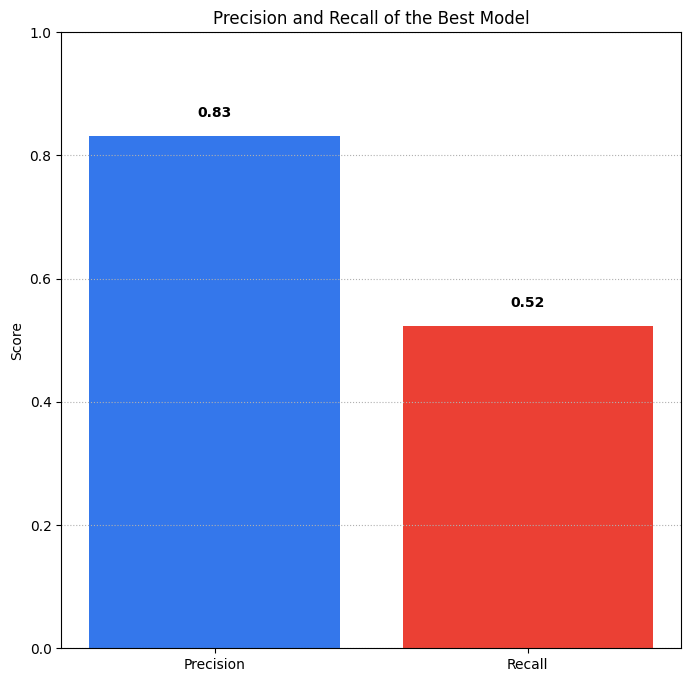

In [86]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)


plt.figure(figsize=(8, 8))
plt.bar(['Precision', 'Recall'], [precision, recall], color=['#3477eb', '#eb4034'])
plt.ylim(0, 1)
plt.title('Precision and Recall of the Best Model')
plt.ylabel('Score')
plt.grid(axis='y', linestyle=':')
for i, v in enumerate([precision, recall]):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

Модель "консервативная": она делает очень мало ложных тревог (FP), но часто не замечает часть ушедших клиентов (FN).

Думаю, что важно не спугнуть лояльных клиентов, так что модель справляется хорошо

Нужно уточнить у заказчика, если приоритет не упустить ни одного потенциального ушедшего, нужно поднимать recall, даже ценой уменьшения precision (например, снизить порог вероятности).




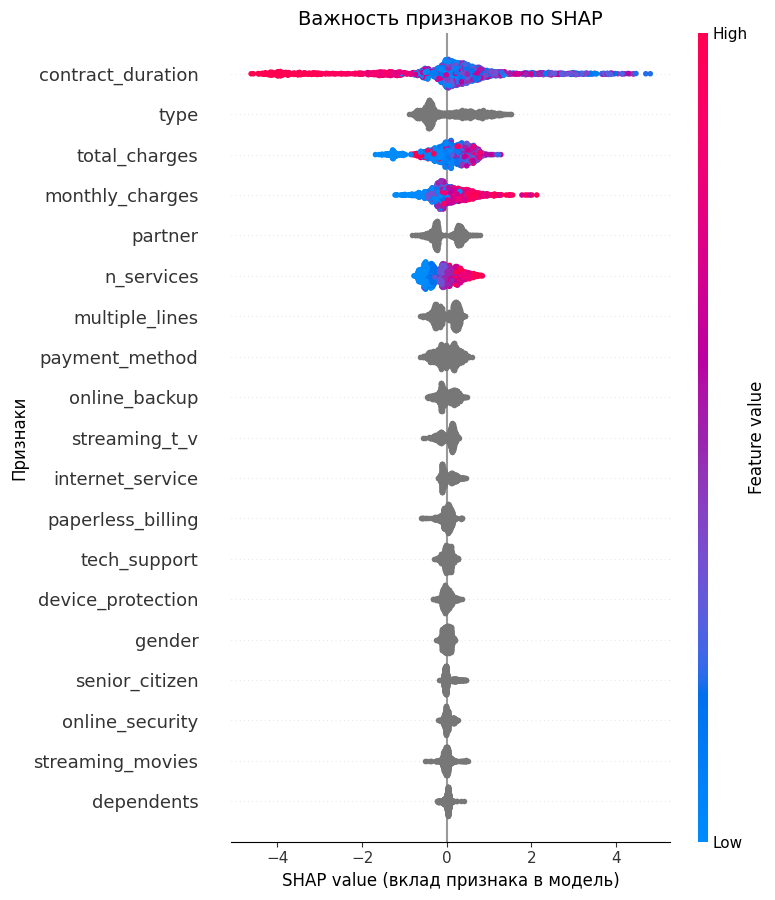

In [87]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False)

plt.xlabel('SHAP value (вклад признака в модель)', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.title('Важность признаков по SHAP', fontsize=14)
plt.tight_layout()
plt.show()

Модель считает, что долгосрочные клиенты и те, кто тратит больше — уходят реже.

На отток также влияет наличие партнёра, количество услуг и размер ежемесячных платежей.

Меньшее влияние оказывают такие признаки как пол, наличие поддержки, доп. услуги и т.п.



Проведём анализ признакак `contract_duration`

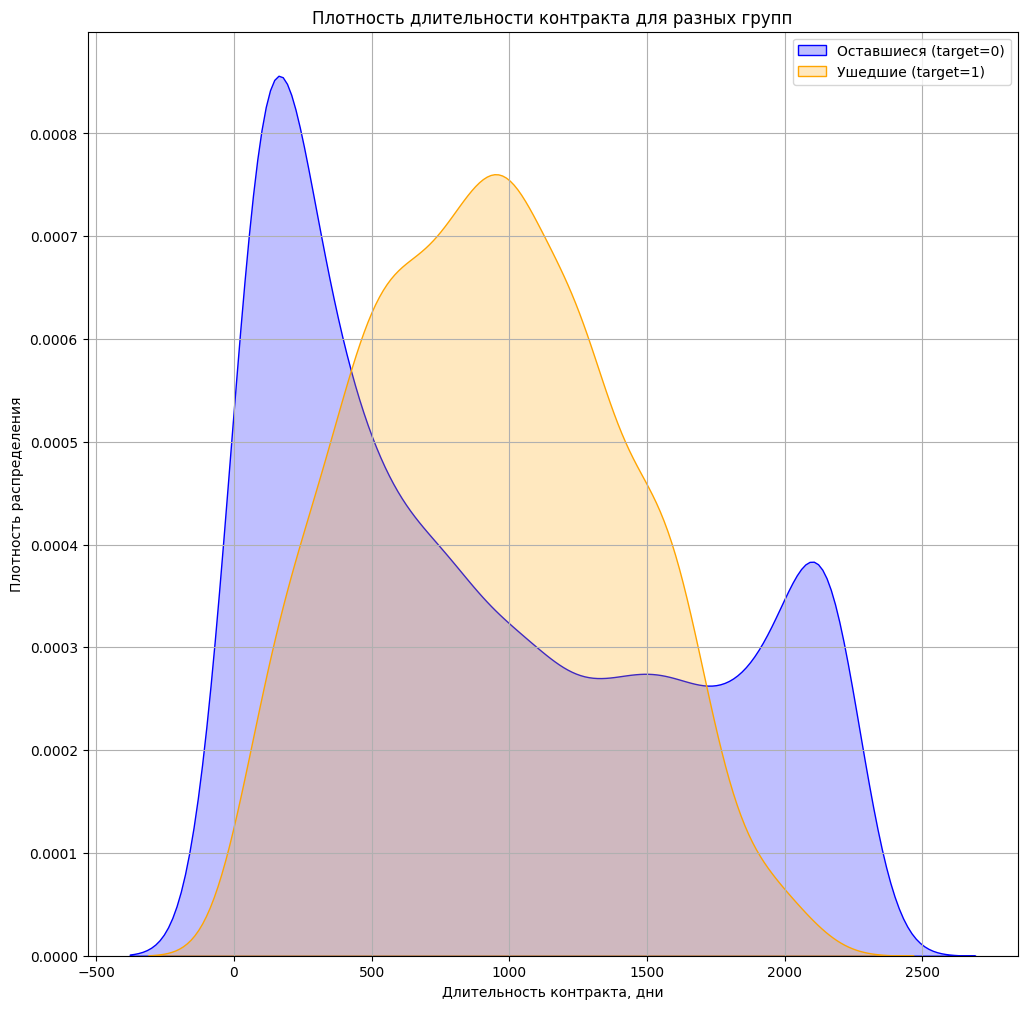

In [88]:
plt.figure(figsize=(12, 12))
sns.kdeplot(
    df.loc[df['target'] == 0, 'contract_duration'], 
    fill=True, color='blue', label='Оставшиеся (target=0)', common_norm=False
)
sns.kdeplot(
    df.loc[df['target'] == 1, 'contract_duration'], 
    fill=True, color='orange', label='Ушедшие (target=1)', common_norm=False
)
plt.xlabel('Длительность контракта, дни')
plt.ylabel('Плотность распределения')
plt.title('Плотность длительности контракта для разных групп')
plt.legend()
plt.grid(True)
plt.show()


Чем дольше длится контракт, тем реже происходит отток, после опредлённого дня (от ~1000 дней) .

Ушедших клиентов больше всего среди тех, у кого контракт среднесрочный.

Среди клиентов с длительными контрактами отток минимален — большинство из них продолжают пользоваться услугами

Основная масса оттока приходится на период 500 - 1500 дней.

С увеличением длительности контракта вероятность ухода снижается.

На больших сроках (от ~2000 дней) отток практически отсутствует, клиенты стабильны.


Думаю, что нужно сфокусироваться на программах лояльности и удержания на клиентах со сроком контракта от 500 до 1500 дней — именно в этой группе наблюдается наибольший отток.


### Вывод 

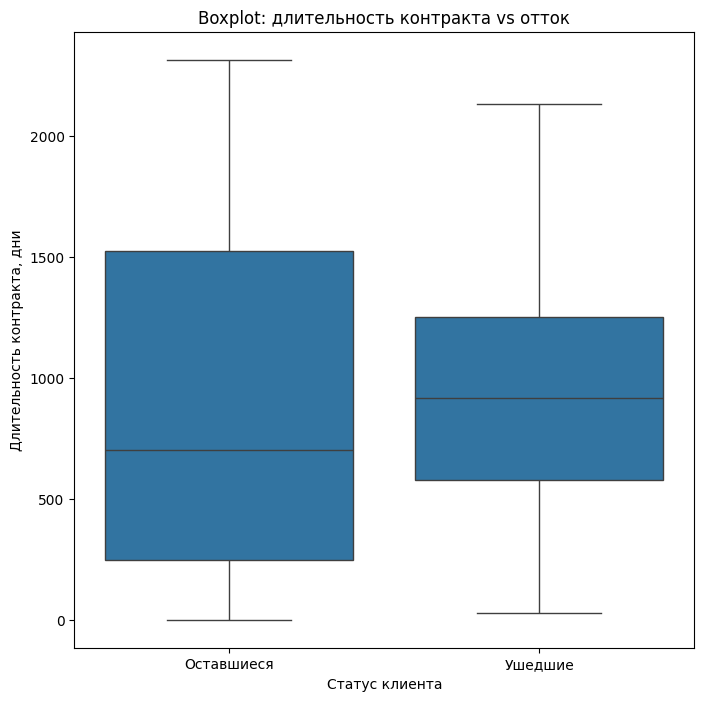

In [89]:
plt.figure(figsize=(8, 8))
sns.boxplot(x='target', y='contract_duration', data=df)
plt.xticks([0, 1], ['Оставшиеся', 'Ушедшие'])
plt.xlabel('Статус клиента')
plt.ylabel('Длительность контракта, дни')
plt.title('Boxplot: длительность контракта vs отток')
plt.show()


Медиана длительности контракта для ушедших клиентов выше, чем для оставшихся.

Ушедшие клиенты чаще имели контракты средней и большой длительности, а не только короткие.

У оставшихся разброс больше: есть и клиенты с минимальным сроком, и те, кто остался на очень долгий срок.

Среди оставшихся медиана ниже, но максимальные значения выше, чем у ушедших.



## Вывод

В ходе проекта были загружены таблицы с помощью SQL запросов, проведена комплексная аналитика имеющихся таблиц и создана единая таблица. Данные были очищены, выбраны наиболее информативные признаки, проведён анализ корреляций (использована Phik-корреляция, более устойчивая для булевых признаков).


 После отбора признаков были обучены и сравненны три модели: случайный лес, CatBoost и нейронная сеть. Лучший результат по метрике ROC-AUC показал CatBoost (ROC-AUC ≈ 0.92). 
 
 Это говорит о высокой способности модели отличать ушедших клиентов от оставшихся.

Анализ важности признаков (через SHAP) показал, что на отток сильнее всего влияют длительность контракта, сумма платежей, количество услуг и наличие партнёра. Клиенты с коротким сроком контракта и небольшими суммами чаще уходят.

Также выявлено, что у многих клиентов риск ухода повышается после определённого срока пользования.

**Рекомендации**

Работать с лояльностью не только новичков, но и клиентов со средним сроком пользования.

Следить за тарифами и услугами, особенно для тех, кто пользуется только базовыми предложениями.

Использовать построенную модель для раннего выявления "группы риска" и точечного удержания.
